In [2]:
import os, sys
sys.path.append('/home/ltetrel/DeepNeuroAN/deepneuroan/')
sys.path.append('/home/ltetrel/DeepNeuroAN/')

import numpy as np
np.set_printoptions(precision=2)
import tensorflow as tf

from preproc import create_ref_grid
import deepneuroan.utils as utils
import SimpleITK as sitk

tf.keras.backend.clear_session()
print(tf.config.list_physical_devices('GPU'))

!python3 -m pip install --user tensorflow_graphics

[]
Keyring is skipped due to an exception: org.freedesktop.DBus.Error.FileNotFound: Failed to connect to socket /run/user/1409/bus: No such file or directory
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
# inputs creation   
batch_size = 10
x = np.empty((batch_size, 9, 9, 9, 1), dtype=np.float64)
trf = np.empty((batch_size, 7), dtype=np.float64)
data_dir = "./data"

for i in range(batch_size):
    x[i, :, :, :, 0] = sitk.GetArrayFromImage(sitk.ReadImage(data_dir + "/ses-vid001_task-video_run-01_bold_vol-0001_transfo-%06d.nii.gz" %(i+1)
                                   , sitk.sitkFloat64))[100:109, 110:119, 120:129]

    trf[i,] = utils.load_trf_file(data_dir + "/ses-vid001_task-video_run-01_bold_vol-0001_transfo-%06d.txt" %(i+1))
    
    # Inversing quaternions to compare volumes with base one
    q = sitk.VersorRigid3DTransform([trf[i, 1], trf[i, 2], trf[i, 3], trf[i, 0]])
    t = sitk.TranslationTransform(3, tuple(trf[i, 4:]))
    q.SetTranslation(t.GetOffset())
    q = q.GetInverse().GetParameters()
    trf[i, 1:4] = [-trf[i, 1], -trf[i, 2], -trf[i, 3]]
    trf[i, 4:] = q[3:]

In [ ]:
class LinearTransformation(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        self.trainable = False
        super(self.__class__, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        if len(input_shape) > 2:
            raise Exception("LinearRegistration must be called on a list of length 2. "
                            "First argument is the volume, second is the quaternion transform.")

        super(self.__class__, self).build(input_shape)

    def call(self, inputs):
        assert isinstance(inputs, list)
        
        #https://www.tensorflow.org/graphics/api_docs/python/tfg/math/interpolation/bspline/interpolate
        #https://www.tensorflow.org/probability/api_docs/python/tfp/math/batch_interp_regular_nd_grid
        #https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/layers/spatial_transformer.html
        
        # map transform across batch
        return tf.map_fn(self._tf_single_transform, inputs, dtype=tf.float32)
            
    def compute_output_shape(self, input_shape):
        return input_shape[0]   
    
    def _single_transform(self, src, trf):
        ref_grid = create_ref_grid()

        sitk_src = utils.get_sitk_from_numpy(src, ref_grid)
        sitk_tgt = utils.transform_volume(sitk_src, ref_grid, rigid=trf)

        return sitk.GetArrayFromImage(sitk_tgt)
    
    @tf.function
    def _tf_single_transform(self, inputs): 
        out = tf.numpy_function(self._single_transform, inp=[inputs[0], inputs[1]], Tout=tf.float32) 
        return out


In [ ]:
#TODO: When it is working, uncomment

# n_batch = 7
# transfos = tf.random.uniform(shape=(n_batch, 7), seed=0) #quaternions (4,) + translations (3,) + scales (3,)
# U = tf.random.uniform((n_batch, 220, 220, 220, 1))
# out_size = [10, 10, 10]
# name='BatchSpatialTransformer3dAffine'

# ref_grid = create_ref_grid()
# sz_ref = ref_grid.GetSize()
# min_ref_grid = ref_grid.GetOrigin()
# max_ref_grid = ref_grid.TransformIndexToPhysicalPoint(sz_ref)

# with tf.compat.v1.variable_scope(name):


In [ ]:
# interpolation on a 3D grid 
import tensorflow_probability as tfp

x_ref_min = np.array([0, 0., 0.], dtype=np.float32)
x_ref_max = np.array([np.pi, np.pi, np.pi], dtype=np.float32)
ny = [100, 100, 100]

# Build y_ref.
x0s, x1s, x2s = tf.meshgrid(
    tf.linspace(x_ref_min[0], x_ref_max[0], ny[0]),
    tf.linspace(x_ref_min[1], x_ref_max[1], ny[1]),
    tf.linspace(x_ref_min[2], x_ref_max[2], ny[2]),
    indexing='ij')

def func(x0, x1, x2):
  # Shape [..., 2] output.
  return tf.sin(x0) + tf.cos(x1) + tf.cos(x2)

# Shape ny + [2]
y_ref = func(x0s, x1s, x2s)

# Shape [10, 2]
seed = 0
x = tf.stack([tf.random.uniform(shape=(10,), minval=x_ref_min[0], maxval=x_ref_max[0], seed=seed),
              tf.random.uniform(shape=(10,), minval=x_ref_min[1], maxval=x_ref_max[1], seed=seed),
              tf.random.uniform(shape=(10,), minval=x_ref_min[2], maxval=x_ref_max[2], seed=seed),
            ], axis=-1)

print(x.shape)
print(y_ref.shape)
expected_y = func(x[:, 0], x[:, 1], x[:, 2])
actual_y = tfp.math.batch_interp_regular_nd_grid(
    x=x, x_ref_min=x_ref_min, x_ref_max=x_ref_max, y_ref=y_ref, axis=-3)
print(expected_y)
print(actual_y)

In [ ]:
src = tf.keras.Input(shape=(9, 9, 9, 1))
inp_flatten = tf.keras.layers.Flatten()(src)
conv = tf.keras.layers.Dense(units=7, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=0), activation=None)(inp_flatten)
reg_out = LinearTransformation()([src, conv])
model = tf.keras.Model(inputs=[src], outputs=[reg_out])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3)
              , loss=["mae"]
              , metrics=["mae"])

res = model.predict(x=[x, trf], batch_size=1)
print(res[0])

In [ ]:
import time
tic = time.time()

src = tf.keras.Input(shape=(220, 220, 220))
y = tf.keras.Input(shape=(7))
reg_out = LinearTransformation()([src, y])
model = tf.keras.Model(inputs=[src, y], outputs=[reg_out])
res = model.predict(x=[x, trf], batch_size=2)
print(len(res))

ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

In [ ]:
#saving output
!rm data/vol*

def save_array_to_sitk(data, name, data_dir):
    ref_grid = create_ref_grid()
    sitk_img = utils.get_sitk_from_numpy(data, ref_grid)
    sitk.WriteImage(sitk_img, os.path.join(data_dir, name + ".nii.gz"))

for vol in range(res.shape[0]):
    save_array_to_sitk(data=res[vol,], name="vol%02d" %(vol+1), data_dir=data_dir)

quaternion rotate here
*** Total 0.721 s ***


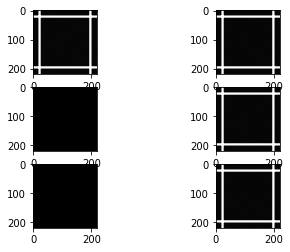

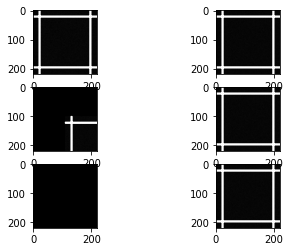

In [83]:
import os, sys
import time
sys.path.append('/home/ltetrel/DeepNeuroAN/deepneuroan/')
sys.path.append('/home/ltetrel/DeepNeuroAN/')
sys.path.append('/home/ltetrel/Documents/work/DeepNeuroAN/deepneuroan/')
sys.path.append('/home/ltetrel/Documents/work/DeepNeuroAN/')

import numpy as np
np.set_printoptions(precision=2)
import tensorflow as tf

from preproc import create_ref_grid
import deepneuroan.utils as utils
import SimpleITK as sitk
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

def mem_size(var):
    return (tf.size(var).numpy() * sys.getsizeof(var.dtype))/(1024**3)

def _old_repeat(x, n_repeats):
    rep = tf.transpose(a=tf.expand_dims(tf.ones(
                                                shape=tf.stack([n_repeats,])
                                                ), 1)
                       , perm=[1, 0])
    rep = tf.cast(rep, dtype=tf.int32)
    x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
    return tf.reshape(x, [-1])

def _repeat(x, num_reps):
    num_reps = tf.cast(num_reps, dtype=tf.int32)
    x = tf.expand_dims(x, axis=1)
    return tf.tile(x, multiples=(1,num_reps))

# def _tf_interpolate(im, p, min_ref_grid, max_ref_grid, method="nn"):
#     return _interpolate(im, p, min_ref_grid, max_ref_grid, method="nn")

def _get_matrices_from_params(transfos, num_elems):
    num_batch = tf.shape(transfos)[0]

    #if the transformations has length > 7, then we apply scaling
    if tf.shape(transfos)[-1] > 7:
        thetas = tf.linalg.diag(transfos[:, -3:])
    else:
        thetas = tf.eye(num_rows=3, batch_shape=[num_batch])
        
    #if the transformations has length > 4, then we apply translation
    if tf.shape(transfos)[-1] > 4:  
        thetas = tf.concat(axis=2, values=[thetas, transfos[:, 4:7, tf.newaxis]])
    else:
        thetas = tf.concat(axis=2, values=[thetas, tf.zeros((num_batch, 3, 1))])

    
    q = tf.expand_dims(transfos[:, :4], axis=1)
    q = tf.tile(q, (1, num_elems, 1))

    return q, thetas

def _quaternion_multiply(q1, q2):
    x1, y1, z1, w1 = tf.unstack(q1, axis=-1)
    x2, y2, z2, w2 = tf.unstack(q2, axis=-1)
    x = x1 * w2 + y1 * z2 - z1 * y2 + w1 * x2
    y = -x1 * z2 + y1 * w2 + z1 * x2 + w1 * y2
    z = x1 * y2 - y1 * x2 + z1 * w2 + w1 * z2
    w = -x1 * x2 - y1 * y2 - z1 * z2 + w1 * w2
    return tf.stack((x, y, z, w), axis=-1)

def _quaternion_rotate(points, q):
    padding = [[0, 0] for _ in range(points.shape.ndims)]
    padding[-1][-1] = 1
    points = tf.pad(tensor=points, paddings=padding, mode="CONSTANT")
    points = _quaternion_multiply(q, points)
    points = _quaternion_multiply(points, tf.concat([(-1) * q[..., :3], q[..., 3:4]], axis=-1))
    return points[..., :3]

# inspired from https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/layers/spatial_transformer.html
@tf.function
def _transform_grid(ref_size_xyz, transfos, min_ref_grid=None, max_ref_grid=None):

    num_batch = tf.shape(transfos)[0]
    num_elems = tf.reduce_prod(ref_size_xyz)
    q, thetas = _get_matrices_from_params(transfos, num_elems)

    #if reference grid not specified, we use [-1, 1]
    num_dims = tf.shape(ref_size_xyz)[0]
    if min_ref_grid is None:
        min_ref_grid = (-1)*tf.ones((num_dims))
    if max_ref_grid is None:
        max_ref_grid = tf.ones((num_dims))

    # grid creation from volume affine
    mz, my, mx = tf.meshgrid(tf.linspace(min_ref_grid[2], max_ref_grid[2], ref_size_xyz[2])
                            , tf.linspace(min_ref_grid[1], max_ref_grid[1], ref_size_xyz[1])
                            , tf.linspace(min_ref_grid[0], max_ref_grid[0], ref_size_xyz[0])
                            , indexing='ij')

    # preparing grid for quaternion rotation
    grid = tf.concat([tf.reshape(mx, (-1, 1)), tf.reshape(my, (-1, 1)), tf.reshape(mz, (-1, 1))], axis=1)
    grid = tf.expand_dims(grid, axis=0)
    grid = tf.tile(grid, (num_batch, 1, 1))

    #quaternion rotation
    grid = _quaternion_rotate(grid, q)

    # preparing grid for translation + scaling
    grid = tf.transpose(grid, perm=[0, 2, 1])
    grid = tf.concat([grid, tf.ones((3, 1, num_elems))], axis=1)
    
    return tf.matmul(thetas, grid)

# inspired from https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/layers/spatial_transformer.html
@tf.function
def _interpolate(im, p, min_ref_grid=None, max_ref_grid=None, method="nn", padding_mode="zero", padding_mode_value=255.):
    
    #constants
    num_batch = tf.cast(tf.shape(im)[0], dtype=tf.float32)
    vol_shape_xyz = tf.cast( tf.concat([tf.shape(im)[1:-1][1::-1], tf.shape(im)[1:-1][2:]], axis=0), dtype=tf.float32)
    width = vol_shape_xyz[0]
    height = vol_shape_xyz[1]
    depth = vol_shape_xyz[2]
    channels = tf.shape(im)[-1]
    num_dims = tf.shape(vol_shape_xyz)[0]
    num_row_major = tf.math.cumprod(vol_shape_xyz)
    zero = tf.zeros([], dtype=tf.float32)
    ibatch = _repeat(num_row_major[-1] * tf.range(num_batch, dtype=tf.float32), num_row_major[-1])
    output = tf.zeros((tf.cast(num_batch, dtype=tf.int32), tf.cast(num_row_major[-1], dtype=tf.int32) , 1), dtype=tf.float32)
    if min_ref_grid is None:
        min_ref_grid = (-1)*tf.ones((num_dims))
    if max_ref_grid is None:
        max_ref_grid = tf.ones((num_dims))

    # scale positions to [0, width/height - 1]
    coeff_x = (width - 1.)/(max_ref_grid[0] - min_ref_grid[0])
    coeff_y = (height - 1.)/(max_ref_grid[1] - min_ref_grid[1])
    coeff_z = (depth - 1.)/(max_ref_grid[2] - min_ref_grid[2])
    ix = (coeff_x * p[:, 0, :]) - (coeff_x *  min_ref_grid[0])
    iy = (coeff_y * p[:, 1, :]) - (coeff_y *  min_ref_grid[1])
    iz = (coeff_z * p[:, 2, :]) - (coeff_z *  min_ref_grid[2])

    # padding mode, for positions outside of refrence grid
    if (padding_mode == "zero") | (padding_mode == "value"):
        valid = tf.expand_dims(tf.cast(tf.less_equal(ix, width - 1.) & tf.greater_equal(ix, zero)
                                        & tf.less_equal(iy, height - 1.) & tf.greater_equal(iy, zero)
                                        & tf.less_equal(iz, depth - 1.) & tf.greater_equal(iz, zero)
                                        , dtype=tf.float32), -1)

    # if we use bilinear interpolation, we calculate each area between corners and positions to get the weights for each input pixel
    if method == "bilinear":
        # get north-west-top corner indexes based on the scaled positions
        ix_nwt = tf.clip_by_value(tf.floor(ix), zero, width - 1.)
        iy_nwt = tf.clip_by_value(tf.floor(iy), zero, height - 1.)
        iz_nwt = tf.clip_by_value(tf.floor(iz), zero, depth - 1.)

        #gettings all offsets to create corners
        offset_corner = [ ['0'*( num_dims - len(bin(i)[2:])) + bin(i)[2:]] for i in range(tf.bitwise.left_shift(1., num_dims)) ]

        # looping on all cube corners and getting corner indexes based on the scaled positions
        for c in range( len(offset_corner) ):
            # area is computed using the opposite corner
            ix_c = ix_nwt + tf.strings.to_number( offset_corner[-c - 1][0][0], out_type=tf.float32)
            iy_c = iy_nwt + tf.strings.to_number( offset_corner[-c - 1][0][1], out_type=tf.float32)
            iz_c = iz_nwt + tf.strings.to_number( offset_corner[-c - 1][0][2], out_type=tf.float32)

            # calculate the weights for each p position
            nc = tf.expand_dims(tf.abs((ix - ix_c) * (iy - iy_c) * (iz - iz_c)), -1)

            # current corner position
            ix_c = ix_nwt + tf.strings.to_number( offset_corner[c][0][0], out_type=tf.float32)
            iy_c = iy_nwt + tf.strings.to_number( offset_corner[c][0][1], out_type=tf.float32)
            iz_c = iz_nwt + tf.strings.to_number( offset_corner[c][0][2], out_type=tf.float32)

            # gather input image values from corners idx, and calculate weighted pixel value
            idx_c = ibatch + tf.math.minimum(width - 1., ix_c) + num_row_major[0] * tf.math.minimum(height - 1., iy_c) + num_row_major[1] * tf.math.minimum(depth - 1, iz_c)
            Ic = tf.gather(tf.reshape(im, [-1, channels]), tf.cast(idx_c, dtype=tf.int32))
            
            output += nc * Ic

    # else if method is nearest neighbor, we get the nearest corner
    elif method == "nn":
        # get rounded indice corner based on the scaled positions
        ix_nn = tf.clip_by_value(tf.round(ix), zero, width - 1.)
        iy_nn = tf.clip_by_value(tf.round(iy), zero, height - 1.)
        iz_nn = tf.clip_by_value(tf.round(iz), zero, depth - 1.)

        # gather input pixel values from nn corner indexes
        idx_nn = ibatch + ix_nn + num_row_major[0] * iy_nn + num_row_major[1] * iz_nn

        output = tf.gather(tf.reshape(im, [-1, channels]), tf.cast(idx_nn, dtype=tf.int32))

    if padding_mode == "zero":
        output = output * valid
    elif padding_mode == "value":
        output = output * valid + padding_mode_value * (1. - valid)

    return output

n_batch = 3
input_size = (220, 220, 220)
#quaternions (4,) + translations (3,) + scales (3,)
transfos = tf.stack( [tf.zeros(shape=(7), dtype=tf.float32), tf.zeros(shape=(7), dtype=tf.float32), (-20)*tf.ones(shape=(7), dtype=tf.float32)] )[:n_batch]
transfos = tf.stack( [[0., 0., 0., 1., 0., 0., 0.], [0.7071, 0., 0., 0.7071, 0., 0., 0.], [0.7071, 0., 0., 0.7071, -20., -20., -20.]] )[:n_batch]

U_single = 5*tf.random.uniform((1, *input_size, 1), seed=0, dtype=tf.float32)

# np.random.seed(0)
# U_single = 255*np.random.rand(1, *input_size, 1)
# U_single[:, 20:25, :, :, :] = 255.
# U_single[:, :, 20:25, :, :] = 255.
# U_single[:, :, :, 20:25, :] = 255.
# U_single[:, 195:200, :, :, :] = 255.
# U_single[:, :, 195:200, :, :] = 255.
# U_single[:, :, :, 195:200, :] = 255.
# U = tf.tile( tf.cast(U_single, dtype=tf.float32), (n_batch, 1, 1, 1, 1,), name=None)

# im = plt.imread('/home/ltetrel/Documents/work/DeepNeuroAN/notebooks/smiley.png')
# U = tf.transpose(tf.stack( [ tf.stack([[255* im] * input_size[-1]], axis=-1) ]*n_batch, axis=0), perm=[0, 2, 3, 1, 4])

data_dir="/home/ltetrel/Documents/work/DeepNeuroAN"
file = os.path.join(data_dir, "ses-vid001_task-video_run-01_bold_vol-0127")
sitk_im = sitk.ReadImage(file + ".nii.gz", sitk.sitkFloat32)
U = tf.expand_dims(sitk.GetArrayFromImage(sitk_im), axis=-1)
U = tf.stack( [U]*n_batch, axis=0)

out_size = (220, 220, 220)


# U_single = 34*tf.random.uniform((1, 15, 15, 15, 1), seed=0, dtype=tf.float32)

# np.random.seed(seed=0)
# U_single = 34*np.random.rand(1, 15, 15, 15, 1)
# U_single[:, 1:2, :, :, :] = 255.
# U_single[:, :, 1:2, :, :] = 255.
# U_single[:, :, :, 1:2, :] = 255.
# U_single[:, 13:14, :, :, :] = 255.
# U_single[:, :, 13:14, :, :] = 255.
# U_single[:, :, :, 13:14, :] = 255.
# U_single[:, :1, :, :, :] = 0.
# U_single[:, :, :1, :, :] = 0.
# # U_single[:, :, :, :4, :] = 0.
# U_single[:, 14:, :, :, :] = 0.
# U_single[:, :, 14:, :, :] = 0.
# # U_single[:, :, :, 36:, :] = 0.

# U = tf.tile( tf.cast(U_single, dtype=tf.float32), (n_batch, 1, 1, 1, 1), name=None)
# out_size = [15, 15, 15]

name='BatchSpatialTransformer3dAffine'

ref_size = tf.shape(U)[1:-1]
ref_size_xyz = tf.concat([ref_size[1::-1], ref_size[2:]], axis=0)
# min[d] and max[d] correspond to cartesian coordinate d (d=0 is x, d=1 is y ..)
name='BatchSpatialTransformer3dAffine'
ref_grid = create_ref_grid()
sz_ref = ref_grid.GetSize()
min_ref_grid = ref_grid.GetOrigin()
max_ref_grid = ref_grid.TransformIndexToPhysicalPoint(sz_ref)

with tf.compat.v1.variable_scope(name):

    input_transformed = _transform_grid(ref_size_xyz, transfos, min_ref_grid, max_ref_grid)
    input_transformed = _interpolate(U, input_transformed, min_ref_grid, max_ref_grid, "nn", padding_mode="border")

    num_batch = tf.shape(U)[0]
    num_channels = tf.shape(U)[-1]
    output = tf.reshape(input_transformed, tf.stack([num_batch, *ref_size, num_channels]))

    tic = time.time()

    input_transformed = _transform_grid(ref_size_xyz, transfos, min_ref_grid, max_ref_grid)
    input_transformed = _interpolate(U, input_transformed, min_ref_grid, max_ref_grid, "nn", padding_mode="border")

    num_batch = tf.shape(U)[0]
    num_channels = tf.shape(U)[-1]
    output = tf.reshape(input_transformed, tf.stack([num_batch, *ref_size, num_channels]))

    # from vprof import runner
    # _old_interpolate(U, input_transformed, min_ref_grid, max_ref_grid, "nn", padding_mode="border")
    # runner.run(_old_interpolate, 'cmhp', args=(U, input_transformed, min_ref_grid, max_ref_grid, "nn", padding_mode="border"), host='localhost', port=8001)

ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

def save_array_to_sitk(data, name, data_dir):
    ref_grid = create_ref_grid()
    sitk_img = utils.get_sitk_from_numpy(data, ref_grid)
    sitk.WriteImage(sitk_img, os.path.join(data_dir, name + ".nii.gz"))

tic = time.time()

for vol in range(output.shape[0]):
    save_array_to_sitk(data=output[vol,], name="vol%02d" %(vol+1), data_dir=data_dir)

    rigid_sitk = sitk.VersorRigid3DTransform(np.array(transfos[vol, :4], dtype=np.float64).flatten())
    translation = sitk.TranslationTransform(3, tuple(np.array(transfos[vol,4:7], dtype=np.float64)))
    rigid_sitk.SetTranslation(translation.GetOffset())
    ref_grid = create_ref_grid()
    brain_to_grid = sitk.Resample(sitk_im, ref_grid, rigid_sitk, sitk.sitkLinear, 0.0, sitk.sitkFloat32)
    sitk.WriteImage(brain_to_grid, os.path.join(data_dir, "vol_sitk%02d" %(vol+1) + ".nii.gz"))

ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

# axis = 1
# plt.subplot(321)
# batch = 0
# plt.imshow(output[batch,:,:,axis,0], cmap="gray", vmin=0, vmax=255)
# plt.subplot(322)
# plt.imshow(U[batch,:,:,axis,0], cmap="gray", vmin=0, vmax=255)

# plt.subplot(323)
# batch = 1
# plt.imshow(output[batch,:,:,axis,0], cmap="gray", vmin=0, vmax=255)
# plt.subplot(324)
# plt.imshow(U[batch,:,:,axis,0], cmap="gray", vmin=0, vmax=255)

# plt.subplot(325)
# batch = 2
# plt.imshow(output[batch,:,:,axis,0], cmap="gray", vmin=0, vmax=255)
# plt.subplot(326)
# plt.imshow(U[batch,:,:,axis,0], cmap="gray", vmin=0, vmax=255)
# plt.show()

# plt.figure()
# plt.subplot(321)
# batch = 0
# plt.imshow(output[batch,:,:,-axis,0], cmap="gray", vmin=0, vmax=255)
# plt.subplot(322)
# plt.imshow(U[batch,:,:,-axis,0], cmap="gray", vmin=0, vmax=255)

# plt.subplot(323)
# batch = 1
# plt.imshow(output[batch,:,:,-axis,0], cmap="gray", vmin=0, vmax=255)
# plt.subplot(324)
# plt.imshow(U[batch,:,:,-axis,0], cmap="gray", vmin=0, vmax=255)

# plt.subplot(325)
# batch = 2
# plt.imshow(output[batch,:,:,-axis,0], cmap="gray", vmin=0, vmax=255)
# plt.subplot(326)
# plt.imshow(U[batch,:,:,-axis,0], cmap="gray", vmin=0, vmax=255)
# plt.show()

In [93]:
a = 3.125
b = 4.876

print(tf.cast(a, dtype=tf.int32))
print(tf.cast(b, dtype=tf.int32))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


In [92]:
a = tf.random.uniform((1, 20000000))

import time

tic = time.time()
for i in range(20):
    tf.round(a)
ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

tic = time.time()
for i in range(20):
    tf.floor(a)
ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))

*** Total 0.534 s ***
*** Total 0.192 s ***


In [80]:
min_ref_grid = tf.constant([-30., -10., 15.,])
max_ref_grid = tf.constant([-18., 10., 37,])
ref_size = tf.shape(tf.ones((4, 7, 3,)))
num_dims = ref_size.shape[0]

lins = []
for i in range(num_dims):
    lins += [tf.linspace(min_ref_grid[i], max_ref_grid[i], ref_size[i])]

M = tf.meshgrid(*lins, indexing='xy')

print(type(M))
print(tf.reduce_prod(ref_size))
print(tf.shape(tf.reshape(M[0], (1, -1))))
# print(M[0])
# print(M[1])
# print(M[2])

<class 'list'>
tf.Tensor(84, shape=(), dtype=int32)
tf.Tensor([ 1 84], shape=(2,), dtype=int32)


In [ ]:
# trying with a simple transform
t_np = np.array([[1, 0, 0, 0]
                 ,[0, 1, 0, -10]
                 ,[0, 0, 1, -30]
                 ,[0, 0, 0, 1]])

affine = sitk.Euler3DTransform()
affine.SetTranslation((-10, 30, 0))

data_dir = "./data"
filepath = data_dir + "/ses-vid001_task-video_run-01_bold_vol-0001_transfo-%06d.nii.gz" %(1)
ref_grid = create_ref_grid()
source_brain = sitk.ReadImage(filepath, sitk.sitkFloat32)

import time
tic = time.time()
for i in range(1):
    brain_to_grid = sitk.Resample(source_brain, ref_grid, affine, sitk.sitkLinear, 0.0, sitk.sitkFloat32)
ElpsTime = time.time() - tic
print("*** Total %1.3f s ***"%(ElpsTime))